In [19]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
import math

def KLT_transfer(Kp,L,T):
    numer = [Kp]
    deno = [T,1]
    
    # modeling the time delay with pade approximation
    delay_approx = ctrl.pade(L,3)
    delay_num, delay_den = delay_approx
    
    system_without_delay = ctrl.TransferFunction(numer, deno)
    delay_tf = ctrl.TransferFunction(delay_num, delay_den)
    system_with_delay = ctrl.series(system_without_delay, delay_tf)
    
    return system_with_delay
    
Kp = -0.000912
L = 1.5
T = 110.5

K = 0.15 / Kp + (0.35 - L*T / ((L + T)*(L + T)))*(T / (Kp * L))
Ti = 0.35 * L + 6.7*L*T*T / (T*T + 2*L*T + 10*L*L)

temp_system = KLT_transfer(Kp, L, T)

recordedTimes = []
tempThreshold = 0
controlThreshold = 0

dt = 0.12
vals = np.full(500*4, 20)

state = 0
response = []
integral = 0
currentresp = 0 # current response
countertime = 0

u0 = 0
y0 = 0

t1 = 0
t2 = 0

To begin the assymetric relay autotuning, the system needs to be brought to an equilibrium working point so that a working point control output $u_0$ and working point system temperature output $y_0$ can be established.

For this simulation, we'll use predetermined PID values to get the system to 20 degrees Celcius. In practice, we should be able to use general PID values from a previous controller to get our system into equilibrium, even if they aren't the optimal values.

Working point output control: -21930.660546811145
Working point temperature: 20.000439290817045


/Users/coltonschwabe/Desktop/PID controller/.venv/lib/python3.13/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/Users/coltonschwabe/Desktop/PID controller/.venv/lib/python3.13/site-packages/control/timeresp.py:1089: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  warnings.warn(


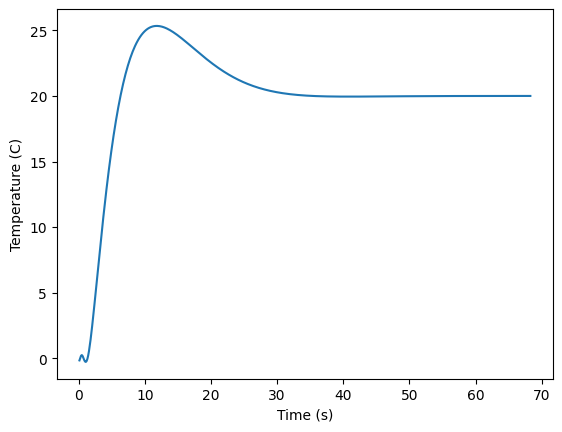

In [20]:
for i in range(0, 2000):
    if (len(recordedTimes) == 0):
        t1 = 0
        t2 = dt
    else:
        t1 = t2
        t2 = t1 + dt

    error = vals[i] - currentresp
    
    PIDval = K/Ti * integral + K * error

    t, r, s = ctrl.forced_response(temp_system, [t1, t2], [PIDval, PIDval], X0=state, return_x = True) #time, response
    currentresp = np.squeeze(r[-1])
    response.append(currentresp)
    recordedTimes.append(t2)

    integral += error * dt

    state = np.squeeze(s[:,-1])

    if (i >= 1): #measures amount of time that temperature and control stays within threshold
        if (countertime == 0): 
            tempThreshold = response[-1]
            controlThreshold = PIDval

            countertime += dt
        elif(abs(tempThreshold - response[-1]) < 0.1 and abs(PIDval - controlThreshold) < 100): #adds to countertime if temperature and controll output are within threshold 
            countertime += dt
        else:
            countertime = 0
    
    if countertime > 10: #if stays within threshold for three seconds, break
        u0 = PIDval
        y0 = response[-1]
        print("Working point output control: " + str(u0))
        print("Working point temperature: " + str(y0))
        
        break

plt.plot(recordedTimes, response)
#plt.plot(recordedTimes, vals, label = 'Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.show()

Note: on the follow graphs shown below, there will be an additional line to indicate $u_{on}$ and $u_{off}$. The height these lines are at is arbitrary because the lines are there simply to show where the relay function is on or off

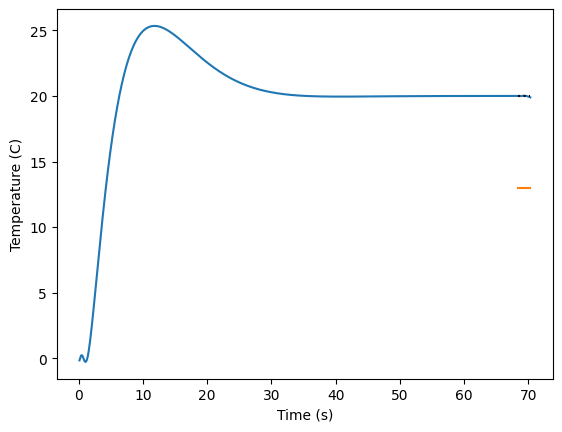

In [21]:
h = 0.1 # hysteresis
d1 = 10000
d2 = 25000

# integrals of system output and control output
Iy = 0
Iu = 0

tOn = 0
tOff = 0

uOn = u0 - d1
uOff = u0 + d2

withinH = True #indicates whether temperature is within hysteresis level

#keeps track of u lines
uTimes = []
uVal = []
y0Arr = []

#intial drop outside of hysteresis
while (abs(y0 - response[-1]) < h):
    t1 = t2
    t2 = t1 + dt

    t, r, s = ctrl.forced_response(temp_system, [t1, t2], [uOff, uOff], X0=state, return_x = True) #time, response
    currentresp = np.squeeze(r[-1])
    response.append(currentresp)
    recordedTimes.append(t2)

    uTimes.append(t2)
    uVal.append(13)
    y0Arr.append(y0)

    state = np.squeeze(s[:,-1])

withinH = False

plt.plot(recordedTimes, response)
plt.plot(uTimes, uVal)
plt.plot(uTimes, y0Arr, linestyle = ":", color = "black")
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.show()

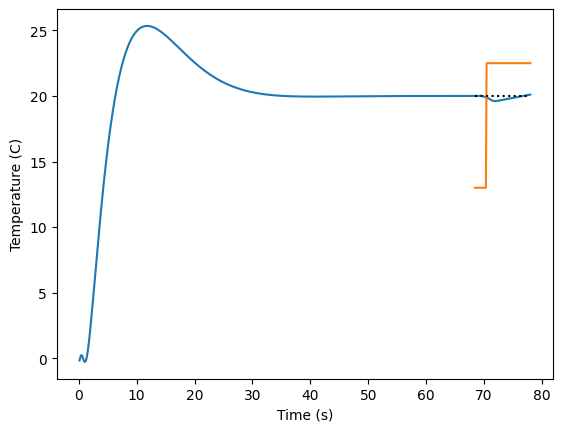

In [22]:
#t_on interval
tOn = t2 # sets start time
while abs(y0 - response[-1]) < h or withinH == False: # will break when temperature passes in and out of hysteresis zone
    if (withinH == False and abs(y0 - response[-1]) < h): withinH = True

    t1 = t2
    t2 = t1 + dt

    t, r, s = ctrl.forced_response(temp_system, [t1, t2], [uOn, uOn], X0=state, return_x = True) #time, response
    currentresp = np.squeeze(r[-1])
    response.append(currentresp)
    recordedTimes.append(t2)

    Iy += (currentresp - y0) * dt
    Iu += (uOn - u0) * dt

    uTimes.append(t2)
    uVal.append(22.5)
    y0Arr.append(y0)

    state = np.squeeze(s[:,-1])

tOn = t2 - tOn # calculates delta t
withinH = False

plt.plot(recordedTimes, response)
plt.plot(uTimes, uVal)
plt.plot(uTimes, y0Arr, linestyle = ":", color = "black")
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.show()

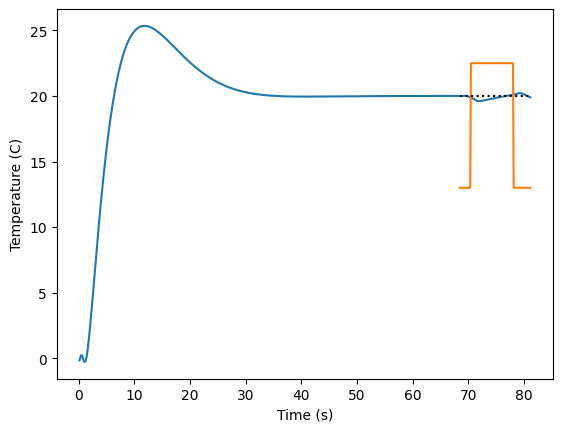

-0.0008512394957687855
1.616852667154783
93.69661206162


In [23]:
#t_off interval
tOff = t2
while abs(y0 - response[-1]) < h or withinH == False: # will break when temperature passes in and out of hysteresis zone
    if (withinH == False and abs(y0 - response[-1]) < h): withinH = True

    t1 = t2
    t2 = t1 + dt

    t, r, s = ctrl.forced_response(temp_system, [t1, t2], [uOff, uOff], X0=state, return_x = True) #time, response
    currentresp = np.squeeze(r[-1])
    response.append(currentresp)
    recordedTimes.append(t2)

    Iy += (currentresp - y0) * dt
    Iu += (uOff - u0) * dt

    uTimes.append(t2)
    uVal.append(13)
    y0Arr.append(y0)

    state = np.squeeze(s[:,-1])

tOff = t2 - tOff # calculates delta t
withinH = False

plt.plot(recordedTimes, response)
plt.plot(uTimes, uVal)
plt.plot(uTimes, y0Arr, linestyle = ":", color = "black")
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.show()

found_Kp = Iy / Iu

gamma = max(d1, d2) / min(d1, d2)
rho = max(tOn, tOff) / min(tOn, tOff)

tau = (gamma - rho) / ((gamma - 1)*(0.35 * rho + 0.65))

L_over_T = tau / (1 - tau)

found_T = tOn / math.log((h / abs(found_Kp) - d2 + math.exp(L_over_T) * (d1 + d2)) / (d1 - h / abs(found_Kp)))

found_L = found_T * L_over_T

print(found_Kp)
print(found_L)
print(found_T)
